In [2]:
from utils import *
from models import *
from training import *

hpc = False
labs = False
paperspace = True

if hpc:
    main_data_path = "/rds/general/user/hsa22/ephemeral/Brain_MINDS/model_data"
    main_logs_path = "/rds/general/user/hsa22/ephemeral/Brain_MINDS/predicted_streamlines"
elif labs:
    main_data_path = "/media/hsa22/Expansion/Brain_MINDS/model_data"
    main_logs_path = "/media/hsa22/Expansion//Brain_MINDS/predicted_streamlines"
elif paperspace:
    main_data_path = "/notebooks/model_data_w_resize"
    main_logs_path = "/notebooks/predicted_streamlines"
else:
    main_data_path = "D:\\Brain-MINDS\\model_data"
    main_logs_path = "D:\\Brain-MINDS\\predicted_streamlines"

streamline_arrays_path = os.path.join(main_logs_path, "streamline_predictions", "resnet_streamlines")
training_log_folder = os.path.join(main_logs_path, "training_logs")
model_folder = os.path.join(main_logs_path, "models", "resnet_streamlines")

check_output_folders(streamline_arrays_path, "streamline arrays", wipe=False)
check_output_folders(training_log_folder, "training_log_folder", wipe=False)
check_output_folders(model_folder, "model_folder", wipe=False)

training_log_path = os.path.join(training_log_folder, "resnet_streamlines.csv")
model_filename = os.path.join(model_folder, "resnet_streamlines.h5")

# Create the configs dictionary
config = {

    ####### Model #######
    "model_name" : "resnet_streamlines", # Model name
    "input_nc" : 1,
    "combination" : True, # Combination
    "task" : "classification", # Task
    "hidden_size" : 32, # number of neurons
    "depthwise_conv" : True, # Depthwise convolution
    "library_opt" : True, # Use stuff from torch_optim
    "contrastive" : "npair", # Contrastive

    ####### Training #######
    "n_epochs" : 50, # Number of epochs
    "loss" : "negative_log_likelihood_loss", # Loss function
    "optimizer" : "Adam", # Optimizer
    "evaluation_metric" : "negative_log_likelihood_loss", # Evaluation metric
    "shuffle_dataset" : True,
    "separate_hemisphere" : False,
    "cube_size" : 5, # cube size
    "save_best" : True, # Save best model
    "overfitting" : False, # Overfitting

    ####### Data #######
    "main_data_path" : main_data_path, # Data path
    "training_log_path" : training_log_path, # Training log path
    "model_filename" : model_filename, # Model filename
    "streamline_arrays_path" : streamline_arrays_path, # Path to the streamlines array
    "batch_size" : 32, # Batch size
    "validation_batch_size" : 32, # Validation batch size
    "num_streamlines" : 10, # Number of streamlines to consider from each site
    
    ####### Parameters #######
    "initial_learning_rate" : 0.05, # Initial learning rate
    "early_stopping_patience": 50, # Early stopping patience
    "decay_patience": 20, # Learning rate decay patience
    "decay_factor": 0.5, # Learning rate decay factor
    "min_learning_rate": 1e-08, # Minimum learning rate
    "save_last_n_models": 10, # Save last n models

    ####### Misc #######
    "skip_val" : False, # Skip validation
    "training_type" : "streamline", # Training type
    "tck_type" : "trk" # TCK type

}


In [3]:
# Get the model information
model_name = config["model_name"]
model_filename = config["model_filename"]
main_data_path = config["main_data_path"]
training_log_path = config["training_log_path"]
residual_arrays_path = config["residual_arrays_path"] if "residual_arrays_path" in config else None
streamline_arrays_path = config["streamline_arrays_path"] if "streamline_arrays_path" in config else None

# Get the training parameters
n_epochs = config["n_epochs"]
learning_rate_decay_patience = config["decay_patience"] if "decay_patience" in config else None
learning_rate_decay_step_size = config["decay_step_size"] if "decay_step_size" in config else None
decay_factor = config["decay_factor"] if "decay_factor" in config else 0.1
min_lr = config["min_learning_rate"] if "min_learning_rate" in config else 0.
early_stopping_patience = config["early_stopping_patience"] if "early_stopping_patience" in config else None
separate_hemisphere = config["separate_hemisphere"] if "separate_hemisphere" in config else True
voxel_wise = config["voxel_wise"] if "voxel_wise" in config else False
cube_size = config["cube_size"] if "cube_size" in config else 5

# Get general parameters
n_gpus = config["n_gpus"] if "n_gpus" in config else 1
n_workers = config["n_workers"] if "n_workers" in config else 1
pin_memory = config["pin_memory"] if "pin_memory" in config else False
prefetch_factor = config["prefetch_factor"] if "prefetch_factor" in config else 1
amp = config["amp"] if "amp" in config else False
save_best = config["save_best"] if "save_best" in config else False
save_every_n_epochs = config["save_every_n_epochs"] if "save_every_n_epochs" in config else None
save_last_n_models = config["save_last_n_models"] if "save_last_n_models" in config else None
verbose = config["verbose"] if "verbose" in config else 1

# Define the output size depending on the task
if in_config("task", config, None) == "classification" and not in_config("contrastive", config, None):
    output_size = 27 # Predicting directions, there are 27 bins
elif in_config("task", config, None) == "regression_angles" and not in_config("contrastive", config, None):
    output_size = 3 # Predicting angles
elif in_config("task", config, None) == "regression_coords" and not in_config("contrastive", config, None):
    output_size = 3 # Predicting coordinates
elif in_config("contrastive", config, None):
    output_size = 256 # Predicting contrastive loss
    
# Build or load the model depending on streamline or dwi training, and build dataset differently
if config["training_type"] == "streamline":
    # Build the model
    model = build_or_load_model(model_name, model_filename, input_nc=config["input_nc"], cube_size=config["cube_size"],
                                num_rnn_layers=in_config("num_rnn_layers", config, None), num_rnn_hidden_neurons=in_config("num_rnn_hidden_neurons", config, None),
                                num_nodes=in_config("num_nodes", config, None), num_coordinates=in_config("num_coordinates", config, None),
                                prev_output_size=in_config("prev_output_size", config, False), combination=config["combination"],
                                n_gpus=n_gpus, bias=None, freeze_bias=in_config("freeze_bias", config, False),
                                strict=False, task=in_config("task", config, "classification"), output_size=output_size,
                                hidden_size=in_config("hidden_size", config, 128), batch_norm=True if config["batch_size"] > 1 else False,
                                depthwise_conv=in_config("depthwise_conv", config, False), contrastive=in_config("contrastive", config, False))
    # Build the dataset
    dataset = StreamlineDataset(main_data_path, num_streamlines=config["num_streamlines"], transforms=None, train=True, tck_type=config["tck_type"], 
                                task=in_config("task", config, "classification"))
elif config["training_type"] == "residual":
    # Build the model
    model = build_or_load_model(model_name, model_filename, input_nc=config["input_nc"], 
                                output_nc=config["output_nc"], ngf=config["ngf"], 
                                num_blocks=config["num_blocks"], norm_layer=config["norm_layer"],
                                use_dropout=config["use_dropout"], padding_type=config["padding_type"],
                                cube_size=config["cube_size"],
                                n_gpus=n_gpus, bias=bias, freeze_bias=in_config("freeze_bias", config, False),
                                strict=False, voxel_wise=config["voxel_wise"])
    # Build the dataset
    dataset = NiftiDataset(main_data_path, transforms=None, train=True)
else:
    raise ValueError("Training type {} not found".format(config["training_type"]))
    
# Print the model name and metric to monitor as logging
print("Model is: {}".format(model.__class__.__name__))


Model is: ResnetEncoder_Streamlines


In [4]:
# If given a task, then get a specific criterion
if in_config("contrastive", config, None):
    if config["contrastive"] == "max_margin":
        criterion = ContrastiveLossWithPosNegPairs()
    elif config["contrastive"] == "npair":
        criterion = MultiClassNPairLoss()
    else:
        raise ValueError("Contrastive loss {} not found".format(config["contrastive"]))
else:
    if in_config("task", config, None) == "classification":
        criterion = negative_log_likelihood_loss
    elif in_config("task", config, None) == "regression_angles" or in_config("task", config, None) == "regression_coords":
        criterion = MSE_loss
    else: # If no task is given, then we need to load one according to the evaluation metric
        criterion = load_criterion(config['evaluation_metric'], n_gpus=n_gpus)

# If weighted loss
if "weights" in config and config["weights"] is not None:
    criterion = loss_funcs.WeightedLoss(torch.tensor(config["weights"]), criterion)
    
print("Criterion is: ", criterion)

# Define the optimizer IF WE'RE NOT USING THE LIBRARY
if in_config("library_opt", config, None) != None:
    # Using MADGRAD
    optimizer = optim.MADGRAD(
    model.parameters(),
    lr=config["initial_learning_rate"],
    momentum=0.9,
    weight_decay=config["decay_factor"] if in_config("decay_factor", config, None) != None else 0,
    eps=1e-6,
    )
else:
    # Optimizer kwargs dictionary
    optimizer_kwargs = dict()

    # If initial learning rate in config
    if "initial_learning_rate" in config:
        optimizer_kwargs["learning_rate"] = config["initial_learning_rate"]

    # Build the optimizer
    optimizer = build_optimizer(optimizer_name=config["optimizer"],
                                model_parameters=model.parameters(),
                                **optimizer_kwargs)

print("Optimizer is", optimizer)
# Get default collate
from torch.utils.data.dataloader import default_collate
collate_fn = default_collate

# Define the split size
proportions = [.75, .10, .15]
lengths = [int(p * len(dataset)) for p in proportions]
lengths[-1] = len(dataset) - sum(lengths[:-1])

# Split the data
seed = torch.Generator().manual_seed(42)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, lengths, generator=seed)

# Define the training loader
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=config["batch_size"],
                                            shuffle=config["shuffle_dataset"],
                                            num_workers=n_workers,
                                            collate_fn=collate_fn,
                                            pin_memory=pin_memory,
                                            prefetch_factor=prefetch_factor)    

# Define the validation loader
val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=config["batch_size"],
                                        shuffle=config["shuffle_dataset"],
                                        num_workers=n_workers,
                                        collate_fn=collate_fn,
                                        pin_memory=pin_memory,
                                        prefetch_factor=prefetch_factor)
    
# Define the test loader
test_loader = torch.utils.data.DataLoader(test_set,
                                            batch_size=config["batch_size"],
                                            shuffle=config["shuffle_dataset"],
                                            num_workers=n_workers,
                                            collate_fn=collate_fn,
                                            pin_memory=pin_memory,
                                            prefetch_factor=prefetch_factor)

Criterion is:  MultiClassNPairLoss()
Optimizer is MADGRAD (
Parameter Group 0
    eps: 1e-06
    k: 0
    lr: 0.05
    momentum: 0.9
    weight_decay: 0.5
)


In [5]:
# Get the next batch from the train loader
(wmfod, streamlines, labels) = next(iter(train_loader))

print("wmfod.shape:", wmfod.shape)
print("streamlines.shape:", streamlines.shape)
print("labels.shape:", labels.shape)

wmfod.shape: torch.Size([32, 45, 128, 178, 115])
streamlines.shape: torch.Size([32, 10, 40, 3])
labels.shape: torch.Size([32, 10, 39])


In [6]:
# Path to the best weights
best_weights_path = "/notebooks/predicted_streamlines/models/resnet_streamlines/resnet_streamlines_best.h5"
# best_weights_path = "/notebooks/Marmoset_Residual_Training/resnet_streamlines_best.h5"
model.load_state_dict(torch.load(best_weights_path))

<All keys matched successfully>

In [7]:
# Define the function to get model output
def batch_loss(model, wmfod_cube, label, previous_predictions, criterion, original_shape, distributed=False, n_gpus=None, use_amp=False,
              training_task="classification", contrastive=False):
    
    # If number of GPUs
    if n_gpus:
        
        # Cast all the data to float if the task is not classification
        if training_task != "classification":
            wmfod_cube = wmfod_cube.float()
            label = label.float()
            previous_predictions = previous_predictions.float()

        # If not running serially, put the data on the GPU
        if not distributed:

            # Empty cache
            torch.cuda.empty_cache()

            # Get all the data on the GPU
            wmfod_cube = wmfod_cube.cuda()
            label = label.cuda()
            previous_predictions = previous_predictions.cuda()
            
            # Get the model on the GPU
            model = model.cuda()
    
    # Compute the output
    if use_amp:
        with torch.cuda.amp.autocast():
            return _batch_loss(model, wmfod_cube, label, previous_predictions, criterion, training_task, original_shape, contrastive=contrastive)
    else:
        return _batch_loss(model, wmfod_cube, label, previous_predictions, criterion, training_task, original_shape, contrastive=contrastive)
    
# Define the batch loss
def _batch_loss(model, wmfod_cube, label, previous_predictions, criterion, training_task, original_shape, contrastive=False):
        
    # Compute the output
    predicted_output = model(wmfod_cube, previous_predictions, original_shape)

    # Get the batch size
    batch_size = label.size(0)
    
    # Find the loss between the output and the label depending on task
    if training_task == "classification":
        loss = criterion(predicted_output, label)
    else:
        loss = criterion(predicted_output.float(), label.float())
            
    # Return the loss
    return predicted_output, loss, batch_size


In [8]:
# Define indices for the coordinates
x_coord = 2
y_coord = 3
z_coord = 4
coordinates = [x_coord, y_coord, z_coord]

# Set the model to evaluation
model.eval()

# Define the kernel size (cube will be 2 * kernel_size) - HYPERPARAMETER
kernel_size = cube_size

# Get the brain hemisphere
brain_hemisphere = get_hemisphere(coordinates, separate_hemisphere, wmfod, kernel_size)

# Get the batch size
batch_size = brain_hemisphere.shape[0]

# Store the previous two predictions, to use as input for the next prediction
previous_prediction_1 = torch.randn((batch_size, output_size))
previous_prediction_2 = torch.randn((batch_size, output_size))
# Concatenate the previous predictions together along dimension 1
previous_predictions = torch.cat((previous_prediction_1, previous_prediction_2), dim=1)

# Define the indices of the streamlines
batch_idx = 0
streamline_idx = 1
node_idx = 2
node_coord_idx = 3

# Create predictions array of the same size as what we'd expect (batch size x number of streamlines x number of nodes x output_size)
# Note that it's either num_nodes - 1 or not, depending on if we're predicting nodes, or predicting directions/angles
predictions_array = np.zeros((batch_size, streamlines.shape[streamline_idx], streamlines.shape[node_idx] - 1, output_size))

# Define a streamline and point to overfit to
streamline = 0
point = 10

# List to store the predicted nodes
predicted_nodes_array = []

# Do this 10k times
while True:

    # Get the current point from the streamline of all batches
    streamline_node = streamlines[:, streamline, point]

    # Get the x, y, z coordinate into a list
    curr_coord = [streamline_node[:, 0], streamline_node[:, 1], streamline_node[:, 2]]

    # Get the current label from all batches
    streamline_label = labels[:, streamline, point]

    # Get the cube in the wmfod that corresponds to this coordinate
    wmfod_cube = grab_cube_around_voxel(image=brain_hemisphere, voxel_coordinates=curr_coord, kernel_size=kernel_size)

    # Turn the cube into a tensor
    wmfod_cube = torch.from_numpy(wmfod_cube).float()

    # Get model output
    (predicted_label, loss, batch_size) = batch_loss(model, wmfod_cube, streamline_label, previous_predictions, criterion, 
                                                        distributed=False, n_gpus=n_gpus, use_amp=False, 
                                                        original_shape=brain_hemisphere.shape, training_task=config["task"],
                                                        contrastive=config["contrastive"])
    
    print("Predicted label is", predicted_label.cpu().detach().numpy())
    print("Loss is", loss.item())

    # If the loss is 0, that means we didn't find a valid pair, so we skip this point
    if loss == 0:
        continue

    # Get the prediction for this node as a numpy array
    predicted_label = predicted_label.cpu().detach().numpy()

    # Add the predicted label to the predictions array
    predictions_array[:, streamline, point] = predicted_label

    if loss != 0:
        break

Predicted label is [[-8.3293748e-04  5.6051939e-45  4.8825863e-29 ... -2.1885492e-13
  -3.8260205e-29 -2.3580080e-13]
 [-8.3300326e-04  5.6051939e-45  4.8825863e-29 ... -2.1885453e-13
  -3.8260205e-29 -2.3580080e-13]
 [-8.3296670e-04  5.6051939e-45  4.8825863e-29 ... -2.1885529e-13
  -3.8260205e-29 -2.3580080e-13]
 ...
 [-8.3302520e-04  5.6051939e-45  4.8825863e-29 ... -2.1885564e-13
  -3.8260205e-29 -2.3580080e-13]
 [-8.3298661e-04  5.6051939e-45  4.8825863e-29 ... -2.1885476e-13
  -3.8260205e-29 -2.3580080e-13]
 [-8.3296740e-04  5.6051939e-45  4.8825863e-29 ... -2.1885456e-13
  -3.8260205e-29 -2.3580080e-13]]
Loss is 1.7165520191192627


In [9]:
streamline_label = streamline_label.cpu().detach().numpy()
labels = streamline_label

print(predicted_label.shape)
print(labels.shape)

(32, 256)
(32,)


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(predicted_label)

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


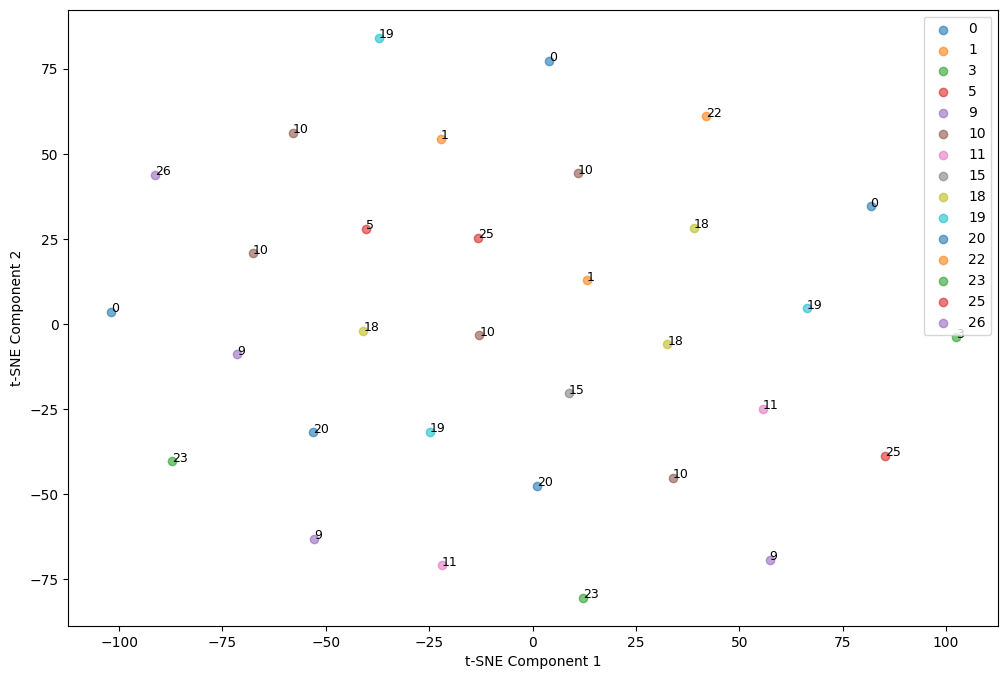

In [11]:
unique_labels = np.unique(labels)
plt.figure(figsize=(12, 8))

for label in unique_labels:
    indices = np.where(labels == label)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.6)

    # Optional: Add text annotation for each point
    for idx in indices[0]:
        plt.text(tsne_results[idx, 0], tsne_results[idx, 1], str(label), fontsize=9)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')
plt.show()
